## **프로젝트: 인물 모드 문제점 찾기**

### **Step 1. 인물모드 직접 해 보기**

In [1]:
# 필요한 라이브러리 import
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

#### **사진을 준비하자**

(4032, 3024, 3)


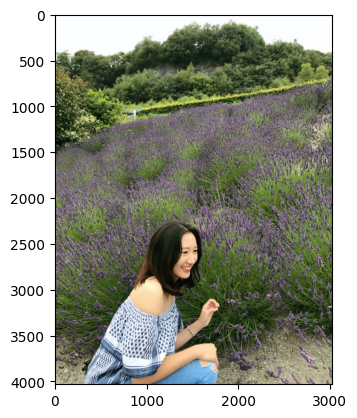

In [2]:
img_path = 'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/me.jpg'  
img_orig = cv2.imread(img_path)
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### **시맨틱 세그멘테이션 다뤄보기**

In [3]:
# 모델 다운로드
# 저장할 파일 이름 결정
model_dir = 'C:/Users/Minjoo Lee/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드 시작
urllib.request.urlretrieve(model_url, model_file)

('C:/Users/Minjoo Lee/aiffel/human_segmentation/models\\deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x230903532c8>)

In [4]:
# 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

1/1 [==============================] - 4s 4s/step


In [6]:
# pascalvoc 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

원본 이미지에서 사람(person) 라벨인 15를 가진 영역만 검출해보도록 하자.

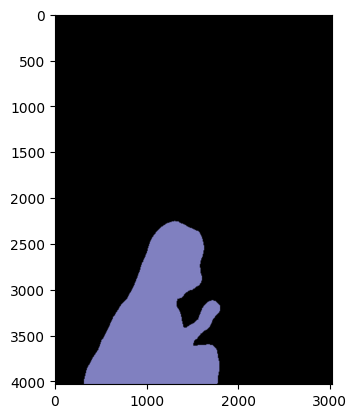

In [7]:
# 출력값 확인
plt.imshow(output)
plt.show()

output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨있는 것을 확인할 수 있다.

In [8]:
# 배열값 출력
segvalues

{'class_ids': array([ 0, 15], dtype=int64),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

segvalues는 class_ids와 masks로 구성되어 있다.

In [9]:
# pacalvoc에 담겨있는 라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


class_ids를 통해서는 어떤 물체가 담겨 있는지 알 수 있다.  

이제 물체마다 ouput에 어떤 색상으로 나타나 있는지 알아내면 될 것 같다.

In [10]:
# 컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
# 컬러맵 15에 해당하는 배열 출력
colormap[15]

array([192, 128, 128])

output 이미지가 BGR 순서로 채널 배치가 되어 있기 때문에 아래와 같이 바꿔줘야 한다.

In [12]:
# 색상 순서 변경
seg_color = (128, 128, 192)

이제 seg_color로만 이루어진 마스크를 만들어보자.

(4032, 3024)


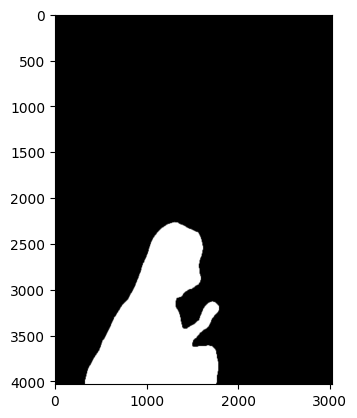

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape)

plt.imshow(seg_map, cmap='gray')
plt.show()

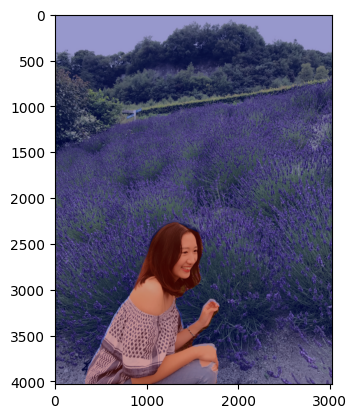

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔주기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 모델이 비교적 잘 동작하여 이미지의 원하는 객체를 검출하고 배경과 잘 구분한 것으로 보인다.

#### **배경 흐리게 하기**

이번에는 blur() 함수를 사용하여 배경을 흐리게 만들어보자.

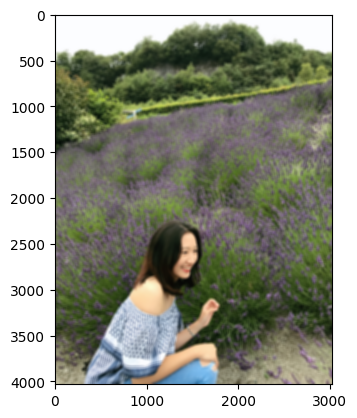

In [15]:
img_orig_blur = cv2.blur(img_orig, (35, 35)) # blurring kernel size

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출해보겠다.

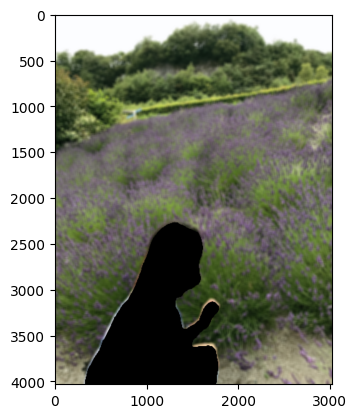

In [16]:
# 입력 이미지의 색상 채널을 변경
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 이미지 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 배경만 있는 영상 추출
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

이미지에서 사람이 사라진 것을 확인할 수 있다.

#### **흐린 배경과 원본 영상 합성**

이제 마지막으로 배경 영상과 사람 영상을 합쳐주자!

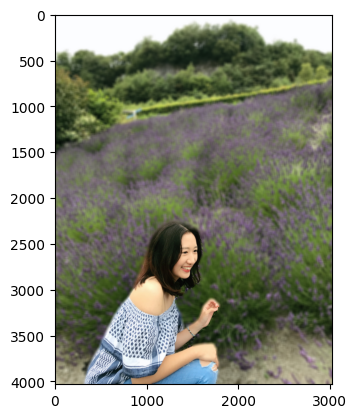

In [17]:
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값
# 아닌 영역은 블러된 이미지 값을 사용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

인물모드가 완성되었다. 원본과 한번 비교해볼까?

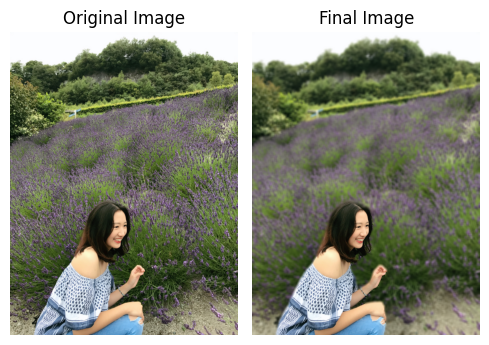

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# 원본 이미지 출력
axes[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')


# 최종 이미지 출력
axes[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
axes[1].set_title('Final Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

멋진 인물 사진이 완성되었다! 이제 다른 사진들도 활용하여 인물모드 사진을 제작해보자.

#### **인물 사진**

인물모드 사진을 제작하는 과정을 함수로 만들어 재사용할 수 있게 하기로 했다.

In [19]:
def create_portrait(img_path, seg_color):
    # 이미지 로드
    img_orig = cv2.imread(img_path)

    # 세그멘테이션 모델 로드
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)

    # 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(img_path)

    # 배경 흐리게 처리
    img_orig_blur = cv2.blur(img_orig, (35, 35))

    # 세그멘테이션 결과에 해당하는 부분 추출
    seg_map = np.all(output == seg_color, axis=-1)

    # 배경과 사람 영역 분리
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    # 최종 이미지 생성
    img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
    
    # 원본 이미지와 최종 이미지 함께 출력
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))

    axes[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Final Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 2s 2s/step


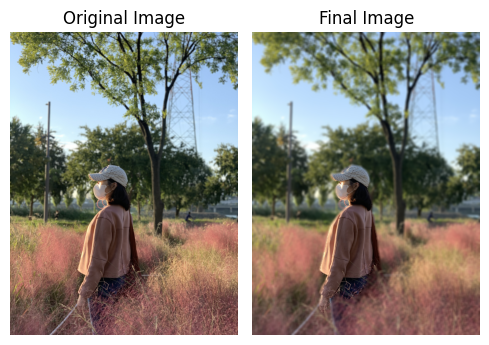

1/1 [==============================] - 2s 2s/step


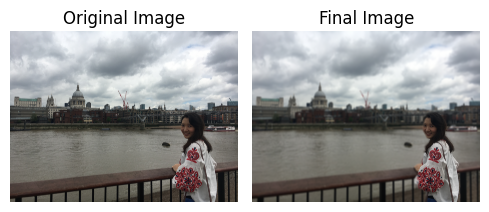

1/1 [==============================] - 1s 1s/step


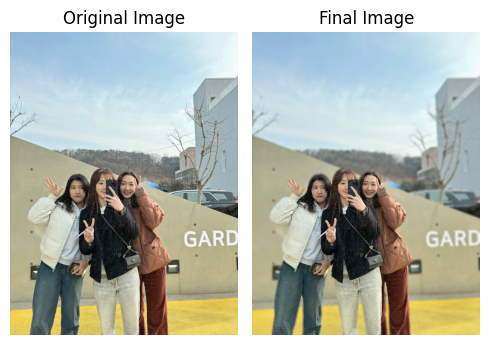

In [20]:
image_paths = [
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/me_1.jpg',
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/me_2.jpg',
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/friends.jpg'
]

for path in image_paths:
    create_portrait(path, (128, 128, 192))

#### **강아지 사진**

강아지에 해당하는 색상 값을 출력해서 확인해보도록 하겠다.

In [21]:
# 컬러맵 12에 해당하는 배열 출력
colormap[12]

array([ 64,   0, 128])

1/1 [==============================] - 1s 1s/step


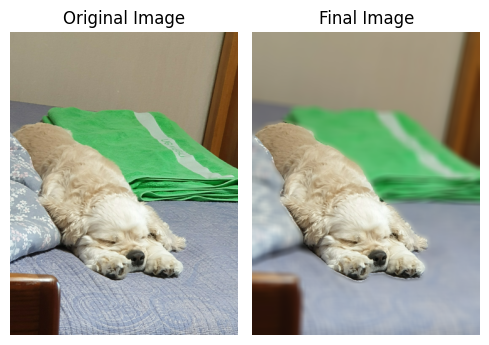

1/1 [==============================] - 1s 1s/step


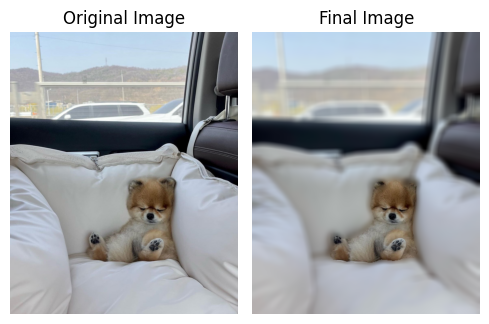

In [22]:
image_paths = [
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/dog_1.jpg',
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/dog_2.png'
]

for path in image_paths:
    create_portrait(path, (128, 0, 64))

#### **고양이 사진**

In [23]:
# 컬러맵 8에 해당하는 배열 출력
colormap[8]

array([64,  0,  0])

1/1 [==============================] - 2s 2s/step


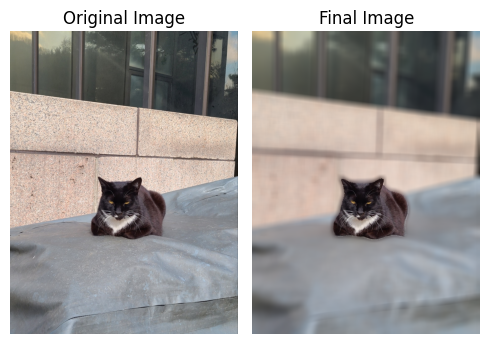

1/1 [==============================] - 1s 1s/step


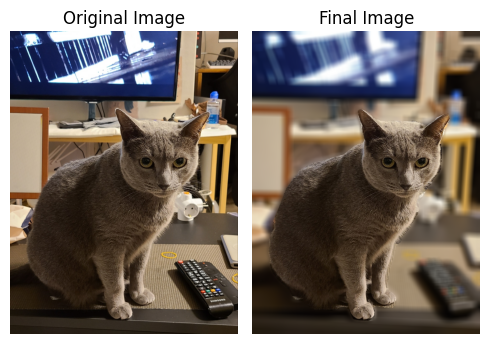

In [24]:
image_paths = [
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/cat_1.jpg',
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/cat_2.jpg',
]

for path in image_paths:
    create_portrait(path, (0, 0, 64))

#### **크로마키 배경**

배경사진을 다른 이미지로 교체하는 크로마키 배경 합성도 시도해보자.

In [25]:
def replace_background(img_path, seg_color, background_path):
    # 이미지 로드
    img_orig = cv2.imread(img_path)
    img_bg = cv2.imread(background_path)

    # 세그멘테이션 모델 로드
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)

    # 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(img_path)

    # 세그멘테이션 결과에 해당하는 부분 추출
    seg_map = np.all(output == seg_color, axis=-1)

    # 배경과 사람 영역 분리
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_fg = cv2.bitwise_and(img_orig, img_mask_color)

    # 배경 이미지 크기 조정
    img_bg_resized = cv2.resize(img_bg, (img_orig.shape[1], img_orig.shape[0]))

    # 크로마키 사진과 사람 영역 합성
    img_concat = np.where(img_mask_color == 255, img_fg, img_bg_resized)

    # 원본 이미지와 최종 이미지 함께 출력
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))

    axes[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Final Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 1s 1s/step


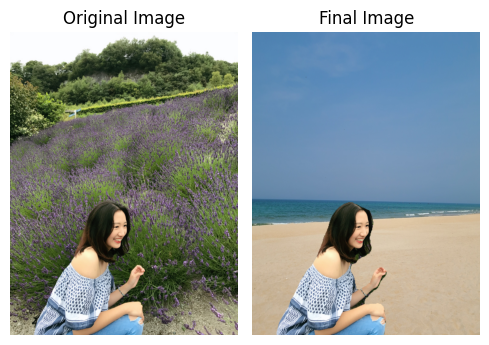

1/1 [==============================] - 1s 1s/step


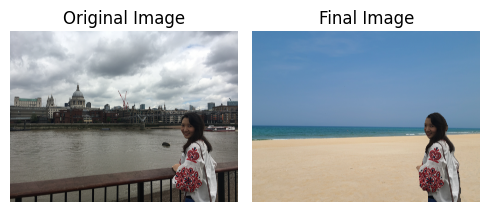

1/1 [==============================] - 1s 1s/step


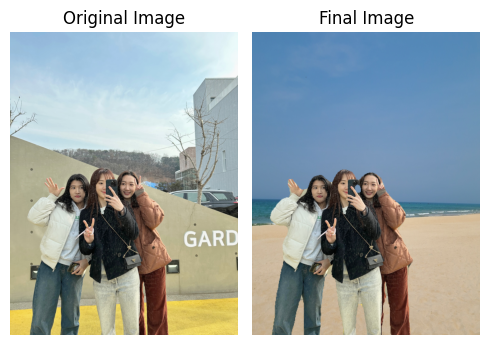

In [26]:
image_paths = [
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/me.jpg',
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/me_2.jpg',
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/friends.jpg'
]

background_path = 'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/background.jpg'

for path in image_paths:
    replace_background(path, (128, 128, 192), background_path)

1/1 [==============================] - 1s 1s/step


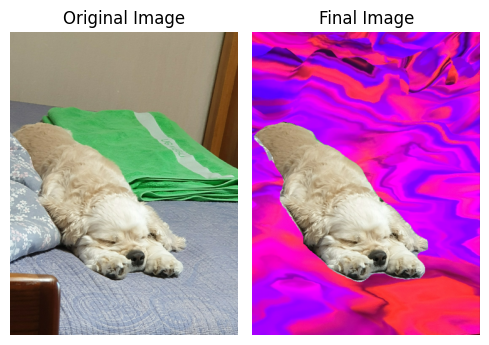

1/1 [==============================] - 1s 1s/step


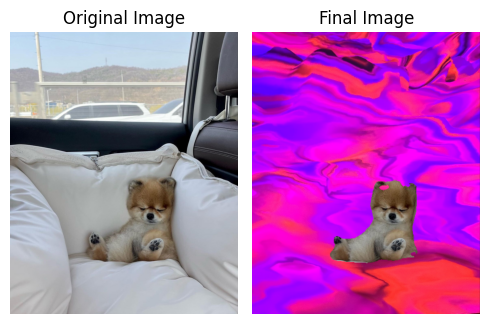

In [27]:
image_paths = [
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/dog_1.jpg',
    'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/dog_2.png',
]

background_path = 'C:/Users/Minjoo Lee/aiffel/human_segmentation/images/background_1.jpg'

for path in image_paths:
    replace_background(path, (128, 0, 64), background_path)

### **Step 2. 사진에서 문제점 찾기**

완성된 인물모드 사진에 어떤 문제점이 있는지 한번 살펴보도록 하자.

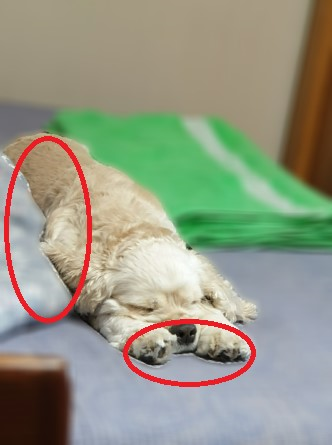

강아지 주변 경계선이 부자연스럽게 그려진다.

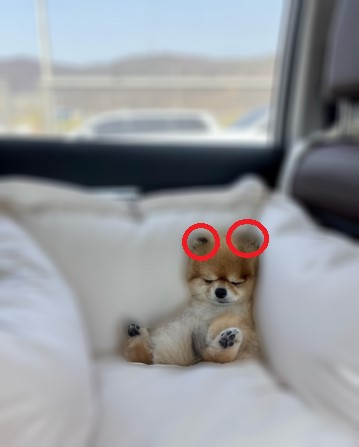

강아지의 귀가 블러 처리된다.

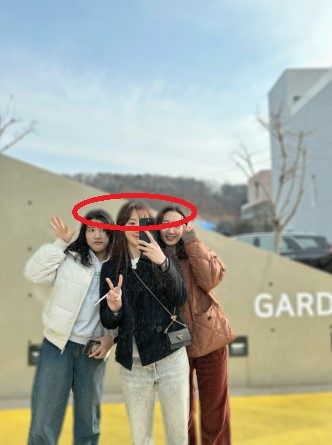

단체 사진에서는 세명의 머리 부분이 함께 블러 처리되었다.

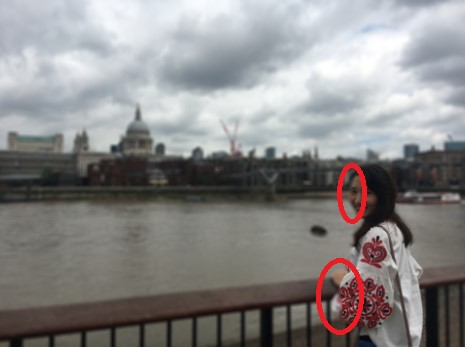

오른쪽 얼굴 부분과 왼쪽 손, 그리고 옷의 일부인 소매까지 블러 처리된 것으로 보인다.  

결론적으로, 인물 세그멘테이션 결과가 부정확하고 불완전하여 경계가 부자연스럽게 그려지거나 일부 영역이 블러 처리되는 문제가 있다.

### **Step 3. 해결 방법을 제안해 보기**

1. 가우시안 블러(Gaussian Blur): 가우시안 블러는 이미지를 부드럽게 만들어 경계 부분을 블러 처리하는 방법이다. 가우시안 함수를 사용하여 각 픽셀의 값을 주변 픽셀들의 가중치와 조합하여 조정한다. 이를 통해 세그멘테이션 결과의 경계를 더 부드럽게 처리할 수 있으며, 자연스럽고 노이즈가 줄어든 결과를 얻을 수 있다.<br>
<br>
2. 알파 블렌딩(Alpha Blending): 알파 블렌딩은 세그멘테이션 결과와 원본 이미지를 부드럽게 혼합하는 방법이다. 세그멘테이션 결과를 알파 채널로 변환하고, 이를 이용하여 세그멘테이션 결과와 원본 이미지를 혼합한다. 알파 채널은 각 픽셀에 대한 투명도 값을 나타내며, 부드러운 혼합을 통해 경계 부분을 자연스럽게 처리할 수 있다.<br>
<br>
3. 모폴로지 연산(Morphological Operations): 모폴로지 연산은 형태학적인 변환을 통해 세그멘테이션 마스크를 개선하는 기법이다. 주로 팽창(Dilation)과 침식(Erosion) 연산을 사용한다. 팽창 연산은 객체 영역을 확장시켜 경계 부분을 더 정확하게 추출하는 데 도움을 주며, 침식 연산은 객체 영역을 축소시켜 불필요한 잡음을 제거하여 세그멘테이션 결과를 개선한다.<br>
<br>
4. 모델 아키텍처 변경: U-Net, Mask R-CNN 등과 같은 딥러닝 기반의 모델을 사용하여 세그멘테이션 결과의 경계를 보정하고 세밀한 처리를 수행할 수 있다. 다양한 모델 아키텍처 중에서 문제에 가장 적합한 모델을 선택하여 사용하는 것이 좋다. 모델의 성능과 경계 부분 처리에 대한 능력을 고려하여 적합한 모델을 선택하면 보다 정확하고 자연스러운 세그멘테이션 결과를 얻을 수 있다.

---

**참고한 레퍼런스**
<br>피사계 심도 https://ko.wikipedia.org/wiki/%ED%94%BC%EC%82%AC%EA%B3%84_%EC%8B%AC%EB%8F%84
<br>Watershed 알고리즘을 이용한 이미지 분할 https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html
<br>DeepLab V3+: Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation https://bloglunit.wordpress.com/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/
<br>PixelLib https://github.com/ayoolaolafenwa/PixelLib
<br>PASCAL VOC http://host.robots.ox.ac.uk/pascal/VOC/
<br>numpy.where https://numpy.org/doc/stable/reference/generated/numpy.where.html
<br>아웃포커싱 하는 법 https://m.blog.naver.com/typs6301/222172333739
<br>얕은 피사계 심도 촬영의 이해 https://www.adobe.com/kr/creativecloud/photography/discover/shallow-depth-of-field.html
<br>3D 이미지센서 https://news.skhynix.co.kr/post/next-gen-3d
<br>Unsupervised Learning of Depth and Ego-Motion: A Structured Approach https://sites.google.com/view/struct2depth
<br>uDepth: Real-time 3D Depth Sensing on the Pixel 4 https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html
<br>OpenCV - 17. 필터(Filter)와 컨볼루션(Convolution) 연산, 평균 블러링, 가우시안 블러링, 미디언 블러링, 바이레터럴 필터 https://bkshin.tistory.com/entry/OpenCV-17-%ED%95%84%ED%84%B0Filter%EC%99%80-%EC%BB%A8%EB%B3%BC%EB%A3%A8%EC%85%98Convolution-%EC%97%B0%EC%82%B0-%ED%8F%89%EA%B7%A0-%EB%B8%94%EB%9F%AC%EB%A7%81-%EA%B0%80%EC%9A%B0%EC%8B%9C%EC%95%88-%EB%B8%94%EB%9F%AC%EB%A7%81-%EB%AF%B8%EB%94%94%EC%96%B8-%EB%B8%94%EB%9F%AC%EB%A7%81-%EB%B0%94%EC%9D%B4%EB%A0%88%ED%84%B0%EB%9F%B4-%ED%95%84%ED%84%B0
<br>OpenCV - 9. 이미지 연산 (합성, 알파 블렌딩, 마스킹) https://bkshin.tistory.com/entry/OpenCV-9-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%97%B0%EC%82%B0
<br>OpenCV - 19. 모폴로지(Morphology) 연산 (침식, 팽창, 열림, 닫힘, 그레디언트, 탑햇, 블랙햇) https://bkshin.tistory.com/entry/OpenCV-19-%EB%AA%A8%ED%8F%B4%EB%A1%9C%EC%A7%80Morphology-%EC%97%B0%EC%82%B0-%EC%B9%A8%EC%8B%9D-%ED%8C%BD%EC%B0%BD-%EC%97%B4%EB%A6%BC-%EB%8B%AB%ED%9E%98-%EA%B7%B8%EB%A0%88%EB%94%94%EC%96%B8%ED%8A%B8-%ED%83%91%ED%96%87-%EB%B8%94%EB%9E%99%ED%96%87
<br>딥러닝 Segmentation(2) - Semantic/Instance Segmentation https://velog.io/@cha-suyeon/%EB%94%A5%EB%9F%AC%EB%8B%9D-Segmentation2-SemanticInstance-Segmentation